In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [2]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "checkpoints/sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, stability_score_thresh=0.6, min_mask_region_area=3000)

In [304]:
image_og = cv2.imread('D:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/main/Iris-Dataset/CASIA-Iris-Thousand/764/L/S5764L04.jpg')
image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)

In [305]:
DoG = cv2.GaussianBlur(image_og, (3, 3), 0) - cv2.GaussianBlur(image_og, (25, 25), 0)
median1 = cv2.medianBlur(DoG, 9)
eroted = cv2.erode(median1, np.ones((3, 3), np.uint8), iterations=1)
median2 = cv2.medianBlur(eroted, 5)
dilated = cv2.dilate(median2, np.ones((3, 3), np.uint8), iterations=1)
eroted = cv2.erode(dilated, np.ones((7, 7), np.uint8), iterations=1)
image = cv2.bitwise_and(image_og, cv2.bitwise_not(eroted))

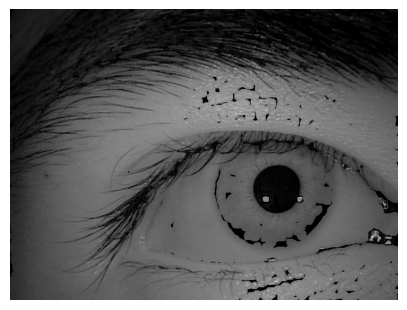

In [306]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [307]:
masks = mask_generator.generate(image_og)

In [308]:
def closest_points(coordinates):
    min_distance = float('inf')
    closest_pair = None

    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            if distance < min_distance:
                min_distance = distance
                closest_pair = (coordinates[i], coordinates[j])

    return closest_pair

In [309]:
def get_outline(mask):
    # Convert the mask to uint8 for compatibility with OpenCV
    mask = mask.astype(np.uint8)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Extract the coordinates of the contours
    outline_coords = []
    for contour in contours:
        outline_coords.append(contour.squeeze().tolist())
    
    return np.array(outline_coords[0])

In [310]:
def is_circle(contour):
    # Calculate area and perimeter of the contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    
    # Threshold for circularity
    circularity_threshold = 0.5
    
    # Check if circularity is above the threshold
    return circularity >= circularity_threshold

In [315]:
df_mask = pd.DataFrame([mask for mask in masks if mask['area'] > 2000 and mask['area'] < 50000])
df_mask['outline'] = df_mask['segmentation'].apply(get_outline)
df_mask['is_circle'] = df_mask['outline'].apply(is_circle)
df_mask = df_mask[df_mask['is_circle']]
df_mask['point_coords'] = df_mask['point_coords'].apply(lambda x: x[0])
close_point = closest_points(df_mask['point_coords'].tolist())
if close_point:
    # close_point = None
    df_mask['valid'] = df_mask['point_coords'].apply(lambda x: True if x in close_point else False)
    df_mask = df_mask[df_mask['valid']]
df_mask = df_mask.sort_values(by='area')

In [316]:
df_mask

,segmentation,area,bbox,predicted_iou,point_coords,stability_score,crop_box,outline,is_circle,valid
0,"[[False, False, False, False, False, False, Fa...",4705,"[402, 258, 75, 77]",1.003746,"[430.0, 262.5]",0.986064,"[0, 0, 640, 480]","[[436, 258], [435, 259], [434, 259], [433, 259...",True,True
4,"[[False, False, False, False, False, False, Fa...",19938,"[338, 232, 196, 161]",0.904520,"[510.0, 277.5]",0.845291,"[0, 0, 640, 480]","[[477, 232], [476, 233], [475, 233], [474, 233...",True,True


In [313]:
def plot_image(image, df_mask, figsize=(10,10)):
    if len(df_mask) < 2:
        return
    pupil_mask_outline = df_mask['outline'].tolist()[0]
    iris_mask_outline = df_mask['outline'].tolist()[1]
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.plot(pupil_mask_outline[:, 0], pupil_mask_outline[:, 1], 'r')
    plt.plot(iris_mask_outline[:, 0], iris_mask_outline[:, 1], 'b')
    plt.title(f'Pupil: {pupil_mask_outline.shape}, Iris: {iris_mask_outline.shape}')
    # plt.axis('off')
    plt.show()

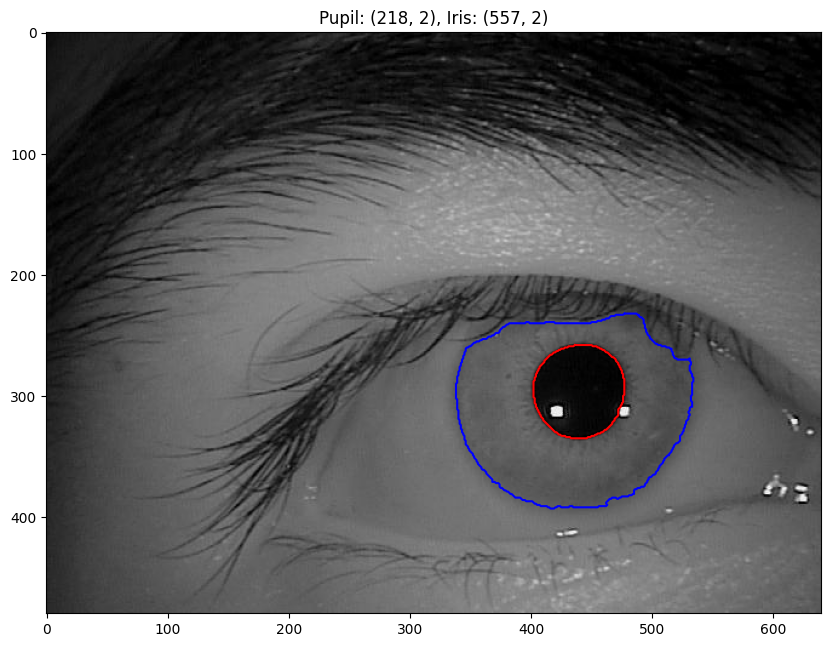

In [314]:
plot_image(image_og, df_mask)

In [224]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

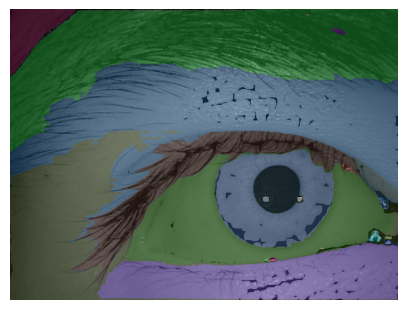

In [225]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [325]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from tqdm.autonotebook import tqdm
import random

def closest_points(coordinates):
    min_distance = float('inf')
    closest_pair = None

    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            if distance < min_distance:
                min_distance = distance
                closest_pair = (coordinates[i], coordinates[j])

    return closest_pair


def get_outline(mask):
    # Convert the mask to uint8 for compatibility with OpenCV
    mask = mask.astype(np.uint8)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Extract the coordinates of the contours
    outline_coords = []
    for contour in contours:
        outline_coords.append(contour.squeeze().tolist())
    
    return np.array(outline_coords[0])


def is_circle(contour):
    # Calculate area and perimeter of the contour
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Calculate circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    
    # Threshold for circularity
    circularity_threshold = 0.7
    
    # Check if circularity is above the threshold
    return circularity >= circularity_threshold


def plot_image(image, df_mask, ax, img_num):
    if len(df_mask) < 2:
        ax.imshow(image)
        for outline in df_mask['outline']:
            ax.plot(outline[:, 0], outline[:, 1], 'r')
        ax.axis('off')
        ax.set_title(f'{img_num} No iris or pupil')
        return
    pupil_mask_outline = df_mask['outline'].tolist()[0]
    iris_mask_outline = df_mask['outline'].tolist()[1]
    ax.imshow(image)
    ax.plot(pupil_mask_outline[:, 0], pupil_mask_outline[:, 1], 'r')
    ax.plot(iris_mask_outline[:, 0], iris_mask_outline[:, 1], 'b')
    ax.set_title(f'{img_num} Pupil: {pupil_mask_outline.shape}, Iris: {iris_mask_outline.shape}')
    ax.axis('off')


def process_image(image_path):
    image_og = cv2.imread(image_path)
    image_og = cv2.cvtColor(image_og, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image_og)
    df_mask = pd.DataFrame([mask for mask in masks if mask['area'] > 2000 and mask['area'] < 50000])
    df_mask['outline'] = df_mask['segmentation'].apply(get_outline)
    df_mask['is_circle'] = df_mask['outline'].apply(is_circle)
    df_mask = df_mask[df_mask['is_circle']]
    df_mask['point_coords'] = df_mask['point_coords'].apply(lambda x: x[0])
    close_point = closest_points(df_mask['point_coords'].tolist())
    if close_point:
        df_mask['valid'] = df_mask['point_coords'].apply(lambda x: True if x in close_point else False)
        df_mask = df_mask[df_mask['valid']]
    df_mask = df_mask.sort_values(by='area')
    return image_og, df_mask

def load_img(base_dir):
    all_image_dirs = []
    for first_dir in os.listdir(base_dir):
        first_dir_path = os.path.join(base_dir, first_dir)
        first_dir_path = f'{base_dir}/{first_dir}'
        for second_dir in os.listdir(first_dir_path):
            second_dir_path = f'{first_dir_path}/{second_dir}'
            third_dir = random.choice(os.listdir(second_dir_path))
            third_dir_path = f'{second_dir_path}/{third_dir}'
            all_image_dirs.append(third_dir_path)
    return all_image_dirs

num_cols = 4

data_dir = load_img("D:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/main/Iris-Dataset/CASIA-Iris-Thousand/")[0:1000]

# Calculate the number of rows based on the number of subdirectories and number of columns
num_rows = len(data_dir) // num_cols + (1 if len(data_dir) % num_cols != 0 else 0)

# Create a grid plot
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
# axes = axes.flatten()
false_outline = 0
for i, image_path in tqdm(enumerate(data_dir), total=len(data_dir)):
    image, df_mask = process_image(image_path)
    # ax = axes[i]
    # plot_image(image, df_mask, ax, i//2)
    false_outline += 1 if len(df_mask) < 2 else 0

# # Remove empty subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.subplots_adjust(wspace=0.1, hspace=-0.5)
# plt.show()

print(f"Accruacy: {(1 - false_outline / len(data_dir)) * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Accruacy: 67.60%
